# Workshop 2: Spatial & Geometry Operations on Vector data

Programación SIG  2025-1S    
Universidad Nacional de Colombia    
Alicia Arévalo Robinson

- Workshop extracted from [Link](https://github.com/lccastillov/prog_sig_2025_1/blob/main/Workshop6_SpatialOpertaions_Vector_Data.ipynb)  
- GitHub Repository: https://github.com/aliciaarevalor/PS

## 0. Modules 🗒️

In [505]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import contextily as cx
from pathlib import Path
from shapely.geometry import Point

import numpy as np
import shapely
from shapely import affinity

## 1. Input data 📂

#### Read files path

In [506]:
# Main folder
root_folder = "./data"

muni_path = root_folder + "/municipios_colombia.shp"

eva_path = root_folder + "/Evaluaciones_Agropecuarias_Municipales_EVA.csv"

ideam_path = root_folder + "/Catalogo_Estaciones_IDEAM.csv"

precip_path = root_folder + "/precipitacion.csv"

road_path = root_folder + "/RedVial.shp"

#### Read CSV files

In [507]:
eva = pd.read_csv(eva_path, encoding='utf-8')
ideam = pd.read_csv(ideam_path,encoding='utf-8')  
precip= pd.read_csv(precip_path, encoding='utf-8')

#### Read GeoDataFrames

In [508]:
# Read and project to EPSG:9377
muni = gpd.read_file(muni_path).to_crs(epsg=9377)
road = gpd.read_file(road_path).to_crs(epsg=9377)

## 2. Data Preprocessing 🧹

### 2.1 `ideam`    

- Read location of ideam stations transforming coordinates to points. Then, read `ideam` as a GeoDataFrame  
- Spatial join `ideam` with `muni` to have geometry municipalities in ideam. This step is for plotting later.  


##### Read `ideam` as a GeoDataGrame

In [509]:
# Convert string coordinates to Points using string manipulation
ideam['geometry'] = ideam['Ubicación'].apply(
    lambda x: Point(
        float(x.strip('()').split(',')[1]),  # longitude
        float(x.strip('()').split(',')[0])   # latitude
    )
)

# Create GeoDataFrame
ideam_gdf = gpd.GeoDataFrame(
    ideam,
    geometry='geometry',
    crs="EPSG:4326"  
)

# Convert to EPSG:9377
ideam_gdf = ideam_gdf.to_crs(9377)

##### Spatial join each station to its municipality (`gpd.sjoin`)

Due that we will join `ideam_gdf` with `muni`, we need to have both GeoDataFrames with the same column for **Municipio**.  
For this, we rename the column **Municipio** to **MPIO_CNMBR** in `ideam_gdf`, and transform all strings to uppercase text. 

In [510]:
ideam_gdf = ideam_gdf.rename(columns={'Municipio': 'MPIO_CNMBR'})
ideam_gdf['MPIO_CNMBR'] = ideam_gdf['MPIO_CNMBR'].str.upper()

##### Join `ideam_gdf` with `muni` using `gpd.sjoin`

In [511]:
stations_with_muni = gpd.sjoin(
    ideam_gdf,   
    muni,         
    how='inner',
    predicate='within'  
)

stations_with_muni

,Codigo,Nombre,Categoria,Estado,Departamento,MPIO_CNMBR_left,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,...,STP34_9_ED,STP51_PRIM,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun
0,52057100,RUMICHACA - AUT [52057100],Limnigráfica,Activa,Nariño,IPIALES,"(0.81378611, -77.66197778)",2582,2016-11-15,NaN,...,2163.0,40870.0,38984.0,12954.0,1333.0,3365.0,1157.0,2.849864,0.127272,52356
1,52055170,LA JOSEFINA - AUT [52055170],Climática Principal,Activa,Nariño,CONTADERO,"(0.93030556, -77.49119444)",2450,2005-12-10,NaN,...,212.0,3200.0,2084.0,407.0,47.0,215.0,66.0,0.327929,0.003498,52210
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,TÚQUERRES,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,...,960.0,20799.0,13139.0,3412.0,477.0,1682.0,478.0,0.755709,0.017506,52838
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,MOCOA,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,...,706.0,14525.0,18219.0,8370.0,1743.0,1437.0,622.0,2.475228,0.105793,86001
4,48015040,PUERTO NARINO - AUT [48015040],Climática Principal,Activa,Amazonas,PUERTO NARIÑO,"(-3.78030556, -70.36263889)",158,2005-07-19,NaN,...,41.0,2512.0,3012.0,429.0,39.0,266.0,726.0,1.968859,0.122363,91540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,4401700167,NIVEL SANGOYACO GARGANTA,Limnimétrica,Activa,Putumayo,MOCOA,"(1.15872222, -76.67080556)",761,2020-02-25,NaN,...,706.0,14525.0,18219.0,8370.0,1743.0,1437.0,622.0,2.475228,0.105793,86001
8969,4401700168,NIVEL MULATO PALMERAS,Limnimétrica,Activa,Putumayo,MOCOA,"(1.15638889, -76.69027778)",966,2020-02-25,NaN,...,706.0,14525.0,18219.0,8370.0,1743.0,1437.0,622.0,2.475228,0.105793,86001
8970,4401700172,NIVEL MOCOA PISCIKART,Limnimétrica,Activa,Putumayo,VILLAGARZÓN,"(1.03964167, -76.61091944)",408,2020-02-25,NaN,...,303.0,8393.0,8784.0,2000.0,266.0,851.0,431.0,1.928017,0.113257,86885
8971,4401700173,NIVEL RUMIYACO LAGARTO,Limnimétrica,Activa,Putumayo,MOCOA,"(1.119225, -76.67045)",647,2020-02-25,NaN,...,706.0,14525.0,18219.0,8370.0,1743.0,1437.0,622.0,2.475228,0.105793,86001


`gpd.sjoin()` returns a gdf with the geometry of the left df, so it is necessary to add a column with the geometry of municipalities

In [512]:
# Add the municipality geometry as a new column
stations_with_muni['muni_geometry'] = stations_with_muni.apply(
    lambda row: muni.loc[row['index_right'], 'geometry'] if pd.notnull(row['index_right']) else None,
    axis=1
)

# Keep relevant columns
stations_with_muni = (stations_with_muni.rename(columns={"MPIO_CNMBR_left": "MPIO_CNMBR"}))
stations_with_muni=stations_with_muni[['Codigo','Nombre','Departamento','MPIO_CNMBR','MPIO_CDPMP','geometry','muni_geometry','DPTO_CCDGO']]
stations_with_muni.head()

,Codigo,Nombre,Departamento,MPIO_CNMBR,MPIO_CDPMP,geometry,muni_geometry,DPTO_CCDGO
0,52057100,RUMICHACA - AUT [52057100],Nariño,IPIALES,52356,POINT (4.48e+06 1.65e+06),"POLYGON ((4.49e+06 1.66e+06, 4.49e+06 1.66e+06...",52
1,52055170,LA JOSEFINA - AUT [52055170],Nariño,CONTADERO,52210,POINT (4.5e+06 1.66e+06),"POLYGON ((4.49e+06 1.66e+06, 4.49e+06 1.66e+06...",52
2,52055220,EL PARAISO - AUT [52055220],Nariño,TÚQUERRES,52838,POINT (4.48e+06 1.68e+06),"POLYGON ((4.49e+06 1.7e+06, 4.49e+06 1.7e+06, ...",52
3,44015070,EL PEPINO - AUT [44015070],Putumayo,MOCOA,86001,POINT (4.59e+06 1.68e+06),"POLYGON ((4.59e+06 1.72e+06, 4.59e+06 1.72e+06...",86
4,48015040,PUERTO NARINO - AUT [48015040],Amazonas,PUERTO NARIÑO,91540,POINT (5.29e+06 1.14e+06),"POLYGON ((5.29e+06 1.15e+06, 5.29e+06 1.15e+06...",91


### 2.2 Get departments names and geometries

##### From `muni`, get departments geometry dissolving the gdf by **DPTO_CCDGO**

In [513]:
departments = muni.dissolve(by='DPTO_CCDGO', as_index=False)
departments=departments[['DPTO_CCDGO', 'geometry']]

##### Merge `departments` with `stations_with_muni` to get the name of each department by their code (DPTO_CCDGO)

In [514]:
# Merge station counts with departments polygons
departments_with_name = departments.merge(
    stations_with_muni,
    how='left',
    on='DPTO_CCDGO',
    validate='one_to_many',  # or 'one_to_many' check all the possibilities     
)

departments_with_name=departments_with_name[['DPTO_CCDGO','Departamento','geometry_x']].drop_duplicates(subset='DPTO_CCDGO')
departments_with_name=departments_with_name.set_geometry('geometry_x')
departments_with_name.head()

,DPTO_CCDGO,Departamento,geometry_x
0,05,Antioquia,"POLYGON ((4.76e+06 2.17e+06, 4.76e+06 2.17e+06..."
1215,08,Atlantico,"POLYGON ((4.8e+06 2.7e+06, 4.8e+06 2.7e+06, 4...."
1325,11,Bogotá,"POLYGON ((4.88e+06 2.09e+06, 4.88e+06 2.09e+06..."
1652,13,Bolívar,"MULTIPOLYGON (((4.9e+06 2.38e+06, 4.9e+06 2.38..."
1963,15,Boyacá,"POLYGON ((5e+06 2.11e+06, 5e+06 2.11e+06, 5e+0..."


Departments from Orinoquia Region

In [515]:
ori=departments_with_name[departments_with_name["Departamento"].isin(["Arauca", "Casanare", "Vichada", "Meta"])].copy()

Municipalities from Orinoquia region

In [559]:
ori_muni = muni[muni["DPTO_CCDGO"].isin(ori["DPTO_CCDGO"])] 
ori_muni['area_km2'] = ori_muni.geometry.area / 1e6
ori_muni = ori_muni[['DPTO_CCDGO', 'MPIO_CNMBR','area_km2', 'geometry']]
ori_muni

c:\Users\VICTUS\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry
185,99,SANTA ROSALÍA,3884.706067,"POLYGON ((5.26e+06 2.15e+06, 5.26e+06 2.15e+06..."
186,99,PUERTO CARREÑO,12142.361360,"POLYGON ((5.57e+06 2.26e+06, 5.57e+06 2.26e+06..."
187,99,LA PRIMAVERA,18286.358754,"POLYGON ((5.44e+06 2.25e+06, 5.44e+06 2.25e+06..."
188,99,CUMARIBO,65319.247163,"POLYGON ((5.5e+06 2.17e+06, 5.5e+06 2.17e+06, ..."
189,85,YOPAL,2476.887302,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06..."
190,85,AGUAZUL,1439.265160,"POLYGON ((5.05e+06 2.15e+06, 5.05e+06 2.15e+06..."
191,85,CHÁMEZA,312.892884,"POLYGON ((5.02e+06 2.15e+06, 5.02e+06 2.15e+06..."
192,85,LA SALINA,199.419246,"POLYGON ((5.07e+06 2.26e+06, 5.07e+06 2.26e+06..."
193,85,MANÍ,3745.281360,"POLYGON ((5.07e+06 2.12e+06, 5.07e+06 2.12e+06..."
194,85,MONTERREY,777.573425,"POLYGON ((5.01e+06 2.11e+06, 5.01e+06 2.11e+06..."


### 2.3 `muni`

Area in km2 of municipalities

In [517]:
muni['area_km2'] = ori_muni.geometry.area / 1e6

##### Organize data

In [518]:
# EVA table, rename code column
eva = (eva.rename(columns={"CÓD. MUN.": "cod_mun"}))

eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

#Homogenise municipalities codes
muni["MPIO_CCDGO"] = muni["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]     = eva["cod_mun"].astype(str).str.zfill(5)

print(f"{len(muni):,} municipalities • {len(ideam):,} stations • "
      f"{len(eva):,} EVA rows")

1,122 municipalities • 8,973 stations • 206,068 EVA rows


##### Merge `muni` and `eva`

This merge is done to work with `eva` as a GeoDataFrame with the geometries of the municipalities

In [519]:
muni_eva = muni.merge(
    eva,
    how='left',                 
    left_on='MPIO_CDPMP',       
    right_on='cod_mun',            
    indicator=True,             
    validate='one_to_many',     
    suffixes=('', '_eva')       
)

### 2.4 Validate CRS of GeoDataFrames 

In [520]:
print("muni CRS:", muni.crs)       
print("ideam CRS:", ideam_gdf.crs)
print("road CRS:", road.crs)   
print("eva CRS:", muni_eva.crs)      
print("departments CRS:", departments_with_name.crs) 

muni CRS: EPSG:9377
ideam CRS: EPSG:9377
road CRS: EPSG:9377
eva CRS: EPSG:9377
departments CRS: EPSG:9377


## 3. Data analysis

### **Level 1: Municipality selection**

#### **Number of IDEAM stations per municipalities**

Count number of stations in each municipality

In [521]:
station_counts = stations_with_muni.groupby('MPIO_CNMBR').size().reset_index(name='station_count')

Merge with `ori_muni`

In [522]:
ori_station_counts = ori_muni.merge(station_counts, on='MPIO_CNMBR', how='left')

# Fill municipalities with no stations with 0
ori_station_counts['station_count'] = ori_station_counts['station_count'].fillna(0).astype(int)

ori_station_counts = ori_station_counts[['DPTO_CCDGO','MPIO_CNMBR','station_count','area_km2','geometry']]

Stations density

In [523]:
ori_station_counts['stations_density']= ori_station_counts['station_count'] / ori_station_counts['area_km2']
ori_station_counts = ori_station_counts.sort_values(by="stations_density", ascending=False)
ori_station_counts

,DPTO_CCDGO,MPIO_CNMBR,station_count,area_km2,geometry,stations_density
37,50,EL CALVARIO,12,277.439283,"POLYGON ((4.92e+06 2.05e+06, 4.92e+06 2.05e+06...",0.043253
30,50,VILLAVICENCIO,28,1283.784072,"POLYGON ((4.92e+06 2.03e+06, 4.92e+06 2.03e+06...",0.021811
6,85,CHÁMEZA,6,312.892884,"POLYGON ((5.02e+06 2.15e+06, 5.02e+06 2.15e+06...",0.019176
53,50,SAN JUANITO,3,236.990181,"POLYGON ((4.93e+06 2.06e+06, 4.93e+06 2.06e+06...",0.012659
34,50,CASTILLA LA NUEVA,6,513.862876,"POLYGON ((4.92e+06 1.99e+06, 4.92e+06 1.99e+06...",0.011676
32,50,BARRANCA DE UPÍA,4,403.029016,"POLYGON ((5e+06 2.07e+06, 5e+06 2.07e+06, 5e+0...",0.009925
31,50,ACACÍAS,11,1122.077275,"POLYGON ((4.91e+06 2.02e+06, 4.91e+06 2.02e+06...",0.009803
39,50,EL DORADO,1,117.175995,"POLYGON ((4.91e+06 1.97e+06, 4.91e+06 1.97e+06...",0.008534
28,81,SARAVENA,8,942.587362,"POLYGON ((5.14e+06 2.34e+06, 5.14e+06 2.34e+06...",0.008487
51,50,SAN CARLOS DE GUAROA,6,806.363303,"POLYGON ((4.96e+06 2e+06, 4.96e+06 2e+06, 4.96...",0.007441


#### **Road density**

Calculate lenght of roads in km

In [524]:
road['length_m'] = road.geometry.length
road['length_km'] = road['length_m'] / 1000

Clip roads to each municipality

In [525]:
road_clip = gpd.overlay(road, ori_muni, how='intersection')
road_clip

,categoria,codigotram,posterefer,distanciai,posteref_1,distanciaf,nombreruta,sector,administra,grupoadmin,...,last_edite,last_edi_1,territoria,revisiones,length_m,length_km,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry
0,1,3002,57,500.0,111,0.0,Transversal Neiva - San Vicente,Santo Domingo - Mina Blanca,1,3,...,SIG_INVIAS,2025-06-10,6,No Revisado,53153.640783,53.153641,50,LA MACARENA,10825.971463,"LINESTRING (4.81e+06 1.82e+06, 4.81e+06 1.82e+..."
1,1,40MTA,80,0.0,94,583.0,Alternas a la Transversal Buenaventura - Villa...,Pipiral - Villavicencio,1,1,...,SIG_INVIAS,2025-06-10,16,No Revisado,14341.070940,14.341071,50,VILLAVICENCIO,1283.784072,"LINESTRING (4.92e+06 2.02e+06, 4.92e+06 2.02e+..."
2,1,6511,0,0.0,49,550.0,Troncal Villagarzon - Saravena,Barranca de Upía - Monterrey,2,None,...,SIG_INVIAS,2025-06-10,7,No Revisado,50685.022012,50.685022,85,MONTERREY,777.573425,"MULTILINESTRING ((5e+06 2.09e+06, 5e+06 2.09e+..."
3,1,6511,0,0.0,49,550.0,Troncal Villagarzon - Saravena,Barranca de Upía - Monterrey,2,None,...,SIG_INVIAS,2025-06-10,7,No Revisado,50685.022012,50.685022,85,SABANALARGA,400.158205,"LINESTRING (5.01e+06 2.08e+06, 5.01e+06 2.08e+..."
4,1,6511,0,0.0,49,550.0,Troncal Villagarzon - Saravena,Barranca de Upía - Monterrey,2,None,...,SIG_INVIAS,2025-06-10,7,No Revisado,50685.022012,50.685022,85,VILLANUEVA,832.164512,"MULTILINESTRING ((5e+06 2.06e+06, 5e+06 2.06e+..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1,6512,103,287.0,105,448.0,Troncal Villagarzon - Saravena,Paso Nacional por Yopal,1,1,...,SIG_INVIAS,2025-06-10,7,No Revisado,2301.678423,2.301678,85,YOPAL,2476.887302,"MULTILINESTRING ((5.07e+06 2.15e+06, 5.07e+06 ..."
78,1,6405,0,0.0,32,80.0,Ruta de Los Libertadores,Sácama - Cruce Ruta 45 (La Cabuya),1,3,...,SIG_INVIAS,2025-06-10,7,No Revisado,31491.551503,31.491552,85,SÁCAMA,311.467073,"LINESTRING (5.08e+06 2.23e+06, 5.08e+06 2.23e+..."
79,1,6405,0,0.0,32,80.0,Ruta de Los Libertadores,Sácama - Cruce Ruta 45 (La Cabuya),1,3,...,SIG_INVIAS,2025-06-10,7,No Revisado,31491.551503,31.491552,85,HATO COROZAL,5492.266109,"LINESTRING (5.1e+06 2.23e+06, 5.1e+06 2.23e+06..."
80,1,6606,0,0.0,44,280.0,Transversal Corredor Fronterizo del Oriente Co...,Corocoro - Arauca,1,4,...,SIG_INVIAS,2025-06-10,7,No Revisado,45262.321353,45.262321,81,ARAUCA,5767.334096,"MULTILINESTRING ((5.25e+06 2.34e+06, 5.25e+06 ..."


Sum road length by municipality

In [526]:
road_length_by_muni = road_clip.groupby('MPIO_CNMBR')['length_km'].sum().reset_index()
road_length_by_muni.rename(columns={'length_km': 'total_road_km'}, inplace=True)
road_length_by_muni

,MPIO_CNMBR,total_road_km
0,ACACÍAS,70.658347
1,AGUAZUL,203.211679
2,ARAUCA,175.713263
3,ARAUQUITA,130.450941
4,BARRANCA DE UPÍA,106.832397
5,CUBARRAL,69.988672
6,CUMARAL,106.832397
7,FORTUL,132.105237
8,FUENTE DE ORO,127.113131
9,GRANADA,294.116886


Merge and compute road density

In [527]:
# Merge road lengths into municipality dataframe
road_muni = ori_muni.merge(road_length_by_muni, on='MPIO_CNMBR', how='right').copy()

# Calculate road density
road_muni['road_density'] = road_muni['total_road_km'] / road_muni['area_km2']
road_muni = road_muni.sort_values(by="road_density", ascending=False)
road_muni

,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry,total_road_km,road_density
9,50,GRANADA,347.802390,"POLYGON ((4.92e+06 1.96e+06, 4.92e+06 1.96e+06...",294.116886,0.845644
13,85,LA SALINA,199.419246,"POLYGON ((5.07e+06 2.26e+06, 5.07e+06 2.26e+06...",122.961939,0.616600
30,85,SÁCAMA,311.467073,"POLYGON ((5.08e+06 2.24e+06, 5.08e+06 2.24e+06...",154.453490,0.495890
26,85,SABANALARGA,400.158205,"POLYGON ((5e+06 2.11e+06, 5e+06 2.11e+06, 5e+0...",143.259185,0.358006
25,50,RESTREPO,364.517064,"POLYGON ((4.94e+06 2.05e+06, 4.94e+06 2.05e+06...",108.611911,0.297961
29,81,SARAVENA,942.587362,"POLYGON ((5.14e+06 2.34e+06, 5.14e+06 2.34e+06...",280.724186,0.297823
35,50,VILLAVICENCIO,1283.784072,"POLYGON ((4.92e+06 2.03e+06, 4.92e+06 2.03e+06...",374.872363,0.292006
4,50,BARRANCA DE UPÍA,403.029016,"POLYGON ((5e+06 2.07e+06, 5e+06 2.07e+06, 5e+0...",106.832397,0.265074
8,50,FUENTE DE ORO,570.099585,"POLYGON ((4.93e+06 1.95e+06, 4.93e+06 1.95e+06...",127.113131,0.222967
15,85,MONTERREY,777.573425,"POLYGON ((5.01e+06 2.11e+06, 5.01e+06 2.11e+06...",152.911011,0.196652


#### **Population served**

In [528]:
ori_population = muni[muni["DPTO_CCDGO"].isin(ori["DPTO_CCDGO"])]
ori_population = ori_population[['DPTO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'area_km2','STP27_PERS', 'geometry']]
ori_population.head()

,DPTO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,area_km2,STP27_PERS,geometry
185,99,SANTA ROSALÍA,99624,3884.706067,4026.0,"POLYGON ((5.26e+06 2.15e+06, 5.26e+06 2.15e+06..."
186,99,PUERTO CARREÑO,99001,12142.361360,19788.0,"POLYGON ((5.57e+06 2.26e+06, 5.57e+06 2.26e+06..."
187,99,LA PRIMAVERA,99524,18286.358754,9690.0,"POLYGON ((5.44e+06 2.25e+06, 5.44e+06 2.25e+06..."
188,99,CUMARIBO,99773,65319.247163,43138.0,"POLYGON ((5.5e+06 2.17e+06, 5.5e+06 2.17e+06, ..."
189,85,YOPAL,85001,2476.887302,156942.0,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06..."


Population density

In [529]:
ori_population['pop_density'] = ori_population['STP27_PERS'] / ori_population['area_km2'] 
ori_population = ori_population.sort_values(by="pop_density", ascending=False)   
ori_population.head()

,DPTO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,area_km2,STP27_PERS,geometry,pop_density
909,50,VILLAVICENCIO,50001,1283.784072,451212.0,"POLYGON ((4.92e+06 2.03e+06, 4.92e+06 2.03e+06...",351.470321
920,50,GRANADA,50313,347.802390,64932.0,"POLYGON ((4.92e+06 1.96e+06, 4.92e+06 1.96e+06...",186.692219
910,50,ACACÍAS,50006,1122.077275,78199.0,"POLYGON ((4.91e+06 2.02e+06, 4.91e+06 2.02e+06...",69.691279
189,85,YOPAL,85001,2476.887302,156942.0,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06...",63.362592
635,81,SARAVENA,81736,942.587362,52884.0,"POLYGON ((5.14e+06 2.34e+06, 5.14e+06 2.34e+06...",56.105144


#### **Proximity to main roads**

Create a buffer of 1 km around roads

In [530]:
road_buffer=road.copy()
road_buffer['geometry_1000'] = road_buffer.geometry.buffer(1000)
road_buffer = road_buffer[['length_km', 'geometry_1000']]
road_buffer=road_buffer.set_geometry("geometry_1000")
road_buffer

,length_km,geometry_1000
0,13.015786,"POLYGON ((4.92e+06 2.48e+06, 4.92e+06 2.48e+06..."
1,3.326309,"POLYGON ((4.92e+06 2.47e+06, 4.92e+06 2.47e+06..."
2,1.397585,"POLYGON ((4.93e+06 2.47e+06, 4.93e+06 2.47e+06..."
3,1.904667,"POLYGON ((4.93e+06 2.47e+06, 4.93e+06 2.47e+06..."
4,3.437777,"POLYGON ((4.95e+06 2.43e+06, 4.95e+06 2.43e+06..."
...,...,...
648,13.191896,"POLYGON ((5e+06 2.2e+06, 5e+06 2.2e+06, 5e+06 ..."
649,0.078243,"POLYGON ((4.81e+06 2.76e+06, 4.81e+06 2.76e+06..."
650,31.300031,"POLYGON ((4.81e+06 2.76e+06, 4.81e+06 2.76e+06..."
651,0.086517,"POLYGON ((5e+06 2.2e+06, 5e+06 2.2e+06, 5e+06 ..."


Overlay `ori_muni` and `road_buffer` 

In [531]:
buffer_muni = gpd.overlay(ori_muni, road_buffer, how='intersection')
buffer_muni

,DPTO_CCDGO,MPIO_CNMBR,area_km2,length_km,geometry
0,99,PUERTO CARREÑO,12142.361360,96.243936,"POLYGON ((5.53e+06 2.23e+06, 5.53e+06 2.23e+06..."
1,85,YOPAL,2476.887302,102.225989,"POLYGON ((5.06e+06 2.14e+06, 5.06e+06 2.14e+06..."
2,85,YOPAL,2476.887302,90.200916,"POLYGON ((5.09e+06 2.17e+06, 5.09e+06 2.17e+06..."
3,85,YOPAL,2476.887302,2.301678,"POLYGON ((5.06e+06 2.15e+06, 5.06e+06 2.15e+06..."
4,85,AGUAZUL,1439.265160,102.225989,"POLYGON ((5.06e+06 2.14e+06, 5.06e+06 2.14e+06..."
...,...,...,...,...,...
87,50,PUERTO GAITÁN,17200.899558,67.481067,"POLYGON ((5.1e+06 2.03e+06, 5.1e+06 2.03e+06, ..."
88,50,PUERTO GAITÁN,17200.899558,7.237254,"POLYGON ((5.18e+06 2.08e+06, 5.18e+06 2.08e+06..."
89,50,PUERTO GAITÁN,17200.899558,19.690192,"POLYGON ((5.17e+06 2.08e+06, 5.17e+06 2.08e+06..."
90,50,PUERTO GAITÁN,17200.899558,21.031549,"POLYGON ((5.16e+06 2.07e+06, 5.16e+06 2.07e+06..."


% of Municipality area within buffer

- Dissolve overlay made before by municipalities

In [532]:
buffer_muni_dissolved = buffer_muni.dissolve(by="MPIO_CNMBR")
buffer_muni_dissolved

,geometry,DPTO_CCDGO,area_km2,length_km
MPIO_CNMBR,,,,
ACACÍAS,"MULTIPOLYGON (((4.91e+06 2.01e+06, 4.91e+06 2....",50,1122.077275,14.341071
AGUAZUL,"POLYGON ((5.06e+06 2.14e+06, 5.06e+06 2.14e+06...",85,1439.265160,102.225989
ARAUCA,"POLYGON ((5.22e+06 2.31e+06, 5.22e+06 2.31e+06...",81,5767.334096,130.450941
ARAUQUITA,"MULTIPOLYGON (((5.22e+06 2.31e+06, 5.22e+06 2....",81,3037.475142,130.450941
BARRANCA DE UPÍA,"POLYGON ((5e+06 2.06e+06, 5e+06 2.06e+06, 5e+0...",50,403.029016,50.685022
CUBARRAL,"POLYGON ((4.92e+06 1.98e+06, 4.92e+06 1.98e+06...",50,1156.421578,69.988672
CUMARAL,"POLYGON ((4.95e+06 2.03e+06, 4.95e+06 2.03e+06...",50,624.000798,106.832397
FORTUL,"POLYGON ((5.15e+06 2.29e+06, 5.15e+06 2.29e+06...",81,1155.454615,132.105237
FUENTE DE ORO,"POLYGON ((4.95e+06 1.93e+06, 4.95e+06 1.92e+06...",50,570.099585,103.594909


- Calculate area of roads buffers

In [533]:
buffer_muni_dissolved['buffer_area_km2'] = buffer_muni_dissolved.geometry.area / 1e6
buffer_muni_dissolved

,geometry,DPTO_CCDGO,area_km2,length_km,buffer_area_km2
MPIO_CNMBR,,,,,
ACACÍAS,"MULTIPOLYGON (((4.91e+06 2.01e+06, 4.91e+06 2....",50,1122.077275,14.341071,39.442361
AGUAZUL,"POLYGON ((5.06e+06 2.14e+06, 5.06e+06 2.14e+06...",85,1439.265160,102.225989,122.968757
ARAUCA,"POLYGON ((5.22e+06 2.31e+06, 5.22e+06 2.31e+06...",81,5767.334096,130.450941,125.954280
ARAUQUITA,"MULTIPOLYGON (((5.22e+06 2.31e+06, 5.22e+06 2....",81,3037.475142,130.450941,121.954766
BARRANCA DE UPÍA,"POLYGON ((5e+06 2.06e+06, 5e+06 2.06e+06, 5e+0...",50,403.029016,50.685022,34.536067
CUBARRAL,"POLYGON ((4.92e+06 1.98e+06, 4.92e+06 1.98e+06...",50,1156.421578,69.988672,7.591479
CUMARAL,"POLYGON ((4.95e+06 2.03e+06, 4.95e+06 2.03e+06...",50,624.000798,106.832397,33.545981
FORTUL,"POLYGON ((5.15e+06 2.29e+06, 5.15e+06 2.29e+06...",81,1155.454615,132.105237,40.309898
FUENTE DE ORO,"POLYGON ((4.95e+06 1.93e+06, 4.95e+06 1.92e+06...",50,570.099585,103.594909,81.425372


- Calculate percentage of municipality area inside roads buffers

In [549]:
buffer_muni_dissolved['area_in_buffer'] = (buffer_muni_dissolved['buffer_area_km2'] / buffer_muni_dissolved['area_km2']) * 100
buffer_muni_dissolved = buffer_muni_dissolved.sort_values(by="area_in_buffer", ascending=False)
buffer_muni_dissolved = buffer_muni_dissolved.reset_index()
buffer_muni_dissolved

,MPIO_CNMBR,geometry,DPTO_CCDGO,area_km2,length_km,buffer_area_km2,area_in_buffer
0,GRANADA,"POLYGON ((4.92e+06 1.94e+06, 4.92e+06 1.94e+06...",50,347.802390,69.988672,81.870508,23.539375
1,SABANALARGA,"POLYGON ((5e+06 2.09e+06, 5e+06 2.09e+06, 5e+0...",85,400.158205,50.685022,67.711106,16.921084
2,SÁCAMA,"MULTIPOLYGON (((5.07e+06 2.22e+06, 5.07e+06 2....",85,311.467073,122.961939,51.731134,16.608861
3,VILLAVICENCIO,"MULTIPOLYGON (((4.92e+06 2e+06, 4.92e+06 2e+06...",50,1283.784072,14.341071,194.755055,15.170390
4,FUENTE DE ORO,"POLYGON ((4.95e+06 1.93e+06, 4.95e+06 1.92e+06...",50,570.099585,103.594909,81.425372,14.282658
5,MONTERREY,"POLYGON ((5.03e+06 2.09e+06, 5.03e+06 2.09e+06...",85,777.573425,50.685022,71.756673,9.228283
6,LA SALINA,"POLYGON ((5.08e+06 2.24e+06, 5.08e+06 2.24e+06...",85,199.419246,122.961939,17.385315,8.717973
7,BARRANCA DE UPÍA,"POLYGON ((5e+06 2.06e+06, 5e+06 2.06e+06, 5e+0...",50,403.029016,50.685022,34.536067,8.569127
8,AGUAZUL,"POLYGON ((5.06e+06 2.14e+06, 5.06e+06 2.14e+06...",85,1439.265160,102.225989,122.968757,8.543857
9,SARAVENA,"POLYGON ((5.14e+06 2.31e+06, 5.14e+06 2.31e+06...",81,942.587362,148.618949,72.499073,7.691496


Plot Roads (with 1 km buffer) in Orinoquia

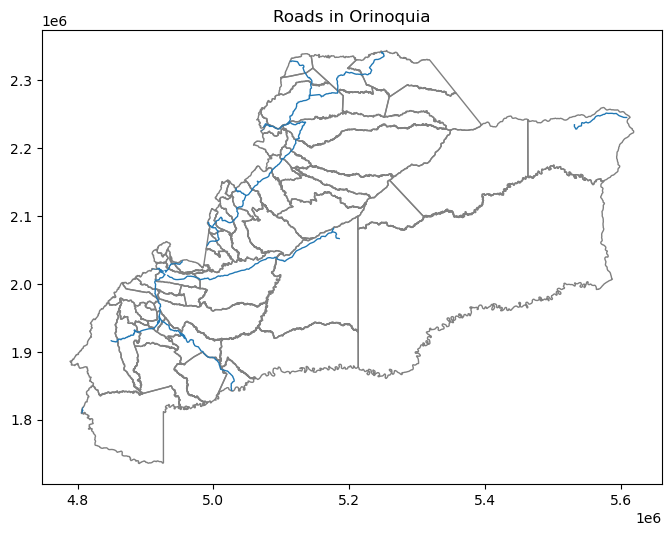

In [535]:
ax = ori_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))
buffer_muni_dissolved.plot(ax=ax)
plt.title("Roads in Orinoquia")
plt.show()

#### **Weighted criteria**

In [563]:
print(len(ori_muni), "municipalities in Orinoquia")
ori_muni

59 municipalities in Orinoquia


,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry
185,99,SANTA ROSALÍA,3884.706067,"POLYGON ((5.26e+06 2.15e+06, 5.26e+06 2.15e+06..."
186,99,PUERTO CARREÑO,12142.361360,"POLYGON ((5.57e+06 2.26e+06, 5.57e+06 2.26e+06..."
187,99,LA PRIMAVERA,18286.358754,"POLYGON ((5.44e+06 2.25e+06, 5.44e+06 2.25e+06..."
188,99,CUMARIBO,65319.247163,"POLYGON ((5.5e+06 2.17e+06, 5.5e+06 2.17e+06, ..."
189,85,YOPAL,2476.887302,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06..."
190,85,AGUAZUL,1439.265160,"POLYGON ((5.05e+06 2.15e+06, 5.05e+06 2.15e+06..."
191,85,CHÁMEZA,312.892884,"POLYGON ((5.02e+06 2.15e+06, 5.02e+06 2.15e+06..."
192,85,LA SALINA,199.419246,"POLYGON ((5.07e+06 2.26e+06, 5.07e+06 2.26e+06..."
193,85,MANÍ,3745.281360,"POLYGON ((5.07e+06 2.12e+06, 5.07e+06 2.12e+06..."
194,85,MONTERREY,777.573425,"POLYGON ((5.01e+06 2.11e+06, 5.01e+06 2.11e+06..."


In [564]:
print(len(buffer_muni_dissolved))
buffer_muni_dissolved

41


,MPIO_CNMBR,geometry,DPTO_CCDGO,area_km2,length_km,buffer_area_km2,area_in_buffer
0,GRANADA,"POLYGON ((4.92e+06 1.94e+06, 4.92e+06 1.94e+06...",50,347.802390,69.988672,81.870508,23.539375
1,SABANALARGA,"POLYGON ((5e+06 2.09e+06, 5e+06 2.09e+06, 5e+0...",85,400.158205,50.685022,67.711106,16.921084
2,SÁCAMA,"MULTIPOLYGON (((5.07e+06 2.22e+06, 5.07e+06 2....",85,311.467073,122.961939,51.731134,16.608861
3,VILLAVICENCIO,"MULTIPOLYGON (((4.92e+06 2e+06, 4.92e+06 2e+06...",50,1283.784072,14.341071,194.755055,15.170390
4,FUENTE DE ORO,"POLYGON ((4.95e+06 1.93e+06, 4.95e+06 1.92e+06...",50,570.099585,103.594909,81.425372,14.282658
5,MONTERREY,"POLYGON ((5.03e+06 2.09e+06, 5.03e+06 2.09e+06...",85,777.573425,50.685022,71.756673,9.228283
6,LA SALINA,"POLYGON ((5.08e+06 2.24e+06, 5.08e+06 2.24e+06...",85,199.419246,122.961939,17.385315,8.717973
7,BARRANCA DE UPÍA,"POLYGON ((5e+06 2.06e+06, 5e+06 2.06e+06, 5e+0...",50,403.029016,50.685022,34.536067,8.569127
8,AGUAZUL,"POLYGON ((5.06e+06 2.14e+06, 5.06e+06 2.14e+06...",85,1439.265160,102.225989,122.968757,8.543857
9,SARAVENA,"POLYGON ((5.14e+06 2.31e+06, 5.14e+06 2.31e+06...",81,942.587362,148.618949,72.499073,7.691496


In [565]:
ori_muni_final = ori_muni.merge(ori_station_counts[['MPIO_CNMBR','stations_density']], on='MPIO_CNMBR', how='left')
ori_muni_final = ori_muni_final.merge(road_muni[['MPIO_CNMBR','road_density']], on='MPIO_CNMBR', how='left')
ori_muni_final = ori_muni_final.merge(ori_population[['MPIO_CNMBR','pop_density']], on='MPIO_CNMBR', how='left')
ori_muni_final = ori_muni_final.merge(buffer_muni_dissolved[['MPIO_CNMBR','area_in_buffer']], on='MPIO_CNMBR', how='left')
ori_muni_final

,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry,stations_density,road_density,pop_density,area_in_buffer
0,99,SANTA ROSALÍA,3884.706067,"POLYGON ((5.26e+06 2.15e+06, 5.26e+06 2.15e+06...",0.001030,NaN,1.036372,NaN
1,99,PUERTO CARREÑO,12142.361360,"POLYGON ((5.57e+06 2.26e+06, 5.57e+06 2.26e+06...",0.000988,0.007926,1.629667,1.606865
2,99,LA PRIMAVERA,18286.358754,"POLYGON ((5.44e+06 2.25e+06, 5.44e+06 2.25e+06...",0.000602,NaN,0.529903,NaN
3,99,CUMARIBO,65319.247163,"POLYGON ((5.5e+06 2.17e+06, 5.5e+06 2.17e+06, ...",0.000337,NaN,0.660418,NaN
4,85,YOPAL,2476.887302,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06...",0.003230,0.078618,63.362592,3.687852
5,85,AGUAZUL,1439.265160,"POLYGON ((5.05e+06 2.15e+06, 5.05e+06 2.15e+06...",0.004864,0.141191,23.234079,8.543857
6,85,CHÁMEZA,312.892884,"POLYGON ((5.02e+06 2.15e+06, 5.02e+06 2.15e+06...",0.019176,NaN,6.420728,NaN
7,85,LA SALINA,199.419246,"POLYGON ((5.07e+06 2.26e+06, 5.07e+06 2.26e+06...",0.000000,0.616600,6.152867,8.717973
8,85,MANÍ,3745.281360,"POLYGON ((5.07e+06 2.12e+06, 5.07e+06 2.12e+06...",0.000000,NaN,3.548732,NaN
9,85,MONTERREY,777.573425,"POLYGON ((5.01e+06 2.11e+06, 5.01e+06 2.11e+06...",0.002572,0.196652,19.069582,9.228283


- Apply a score for each criteria

In [569]:
ori_muni_final['final_score']= (
    0.25 * ori_muni_final['stations_density'] +
    0.25 * ori_muni_final['road_density'] +
    0.25 * ori_muni_final['pop_density'] +
    0.25 * ori_muni_final['area_in_buffer'])

ori_muni_final= ori_muni_final.sort_values(by="final_score", ascending=False)
ori_muni_final

,DPTO_CCDGO,MPIO_CNMBR,area_km2,geometry,stations_density,road_density,pop_density,area_in_buffer,final_score
30,50,VILLAVICENCIO,1283.784072,"POLYGON ((4.92e+06 2.03e+06, 4.92e+06 2.03e+06...",0.021811,0.292006,351.470321,15.170390,91.738632
41,50,GRANADA,347.802390,"POLYGON ((4.92e+06 1.96e+06, 4.92e+06 1.96e+06...",0.000000,0.845644,186.692219,23.539375,52.769309
31,50,ACACÍAS,1122.077275,"POLYGON ((4.91e+06 2.02e+06, 4.91e+06 2.02e+06...",0.009803,0.062971,69.691279,3.515120,18.319793
4,85,YOPAL,2476.887302,"POLYGON ((5.07e+06 2.17e+06, 5.07e+06 2.17e+06...",0.003230,0.078618,63.362592,3.687852,16.783073
28,81,SARAVENA,942.587362,"POLYGON ((5.14e+06 2.34e+06, 5.14e+06 2.34e+06...",0.008487,0.297823,56.105144,7.691496,16.025738
50,50,RESTREPO,364.517064,"POLYGON ((4.94e+06 2.05e+06, 4.94e+06 2.05e+06...",0.000000,0.297961,48.310496,6.781534,13.847498
20,85,VILLANUEVA,832.164512,"POLYGON ((5.02e+06 2.08e+06, 5.02e+06 2.08e+06...",0.000000,0.189286,38.125875,3.984416,10.574894
36,50,CUMARAL,624.000798,"POLYGON ((4.94e+06 2.04e+06, 4.94e+06 2.04e+06...",0.004808,0.171206,34.290020,5.375952,9.960496
40,50,FUENTE DE ORO,570.099585,"POLYGON ((4.93e+06 1.95e+06, 4.93e+06 1.95e+06...",0.005262,0.222967,20.345568,14.282658,8.714114
5,85,AGUAZUL,1439.265160,"POLYGON ((5.05e+06 2.15e+06, 5.05e+06 2.15e+06...",0.004864,0.141191,23.234079,8.543857,7.980998


### **Level 2: Best location within selected municipality**